# Software Requirements Classification
## SVC - Support Vector Classification

In [52]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv')
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0)

In [53]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [54]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern = re.compile(r"[^a-zA-Z]")

def req_to_words(req):
    """Convert requirement text into a sequence of words after lemmatization."""
    # Convert to lower case
    text = req.lower()
    # Remove unwanted characters
    text = re.sub(pattern, " ", text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    words = [w for w in words if w not in STOPWORDS]
    # Apply lemmatization
    # words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    # Apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    return words

# Example use
print("\nOriginal requirement ->", df['Requirement'][0])
print("\nProcessed requirement ->", req_to_words(df['Requirement'][0]))


Original requirement -> The system shall refresh the display every 60 seconds.

Processed requirement -> ['system', 'shall', 'refresh', 'display', 'everi', 'second']


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

### Vectorization

In [56]:
y = df['Type'] # Target
X = [' '.join(req_to_words(req)) for req in df['Requirement']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [57]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Model

In [58]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Example range; adjust based on preliminary results
    'gamma': [1, 0.1, 0.01, 0.001],  # Example range; adjust based on preliminary results
    'kernel': ['rbf']  # Start with RBF kernel; consider trying other kernels separately
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validated score: 0.8583369549471245


In [59]:
model = SVC(C=10, gamma=0.1, kernel='rbf')
model.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

In [60]:
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 86.70%
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       176
           1       0.88      0.88      0.88       215

    accuracy                           0.87       391
   macro avg       0.87      0.87      0.87       391
weighted avg       0.87      0.87      0.87       391


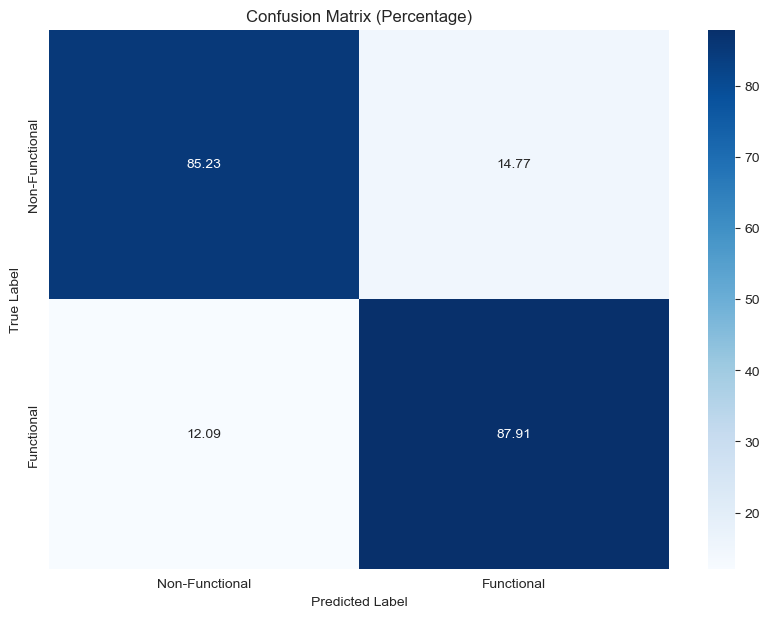

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Convert to percentage
cm_percentage = cm_normalized * 100

# Visualize the confusion matrix as percentages
plt.figure(figsize=(10,7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Testing

In [62]:
def predict_req(req, expected, model, vectorizer):
    df = pd.DataFrame([req], columns=['Requirement'])
    X = [' '.join(req_to_words(req)) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [63]:
def summarize_predictions(examples, model, vectorizer):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [64]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [65]:
summary = summarize_predictions(examples, model, vectorizer)
summary

,Requirement,Expected Label,Predicted Label,Success
0,The system shall provide a login form that acc...,Functional,Functional,True
1,The application must ensure that response time...,Non-Functional,Non-Functional,True
2,All user passwords shall be encrypted before s...,Functional,Functional,True
3,The software should be compatible with the Win...,Non-Functional,Non-Functional,True
4,The interface shall refresh when new data is a...,Functional,Non-Functional,False
5,The product shall comply with international ac...,Non-Functional,Non-Functional,True
6,Database backup shall occur every 24 hours aut...,Functional,Non-Functional,False
7,The system shall support a minimum of 500 conc...,Functional,Non-Functional,False
8,The system’s mean time to failure shall be at ...,Non-Functional,Non-Functional,True
9,Users must be able to complete the primary wor...,Non-Functional,Non-Functional,True


In [66]:
import plotly.express as px

fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()